# Final Exam

**Name Surname**: Emre Girgin \
**Student ID**: 2016400099

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax 
import jax.numpy as jnp
%env JAX_PLATFORM_NAME=cpu
np.random.seed(0)

env: JAX_PLATFORM_NAME=cpu


## Question 1

### a.

If a vector is in the range of a matrix, it should not change when we project it into A. ([Source](https://math.stackexchange.com/a/3062905)) 

In [2]:
def verify(U, x):
    _x = x.reshape(-1, 1)
    proj_m = U @ np.linalg.inv(U.T @ U) @ U.T
    
    proj = proj_m @ _x
    
    diff = proj - _x
    
    if np.abs(sum(diff)) <= 0.001:
        return True
    else:
        return False

### b.

If the vector $z$ is present in both range$(A)$ and range$(B)$, then there exists vectors $x$ and $y$ such that $z = Ax = By$. \
Thus $Ax - By = 0$ and $\begin{bmatrix} A & | & -B \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} = 0$ \
We need to find the nullspace of the $\begin{bmatrix} A & | & -B \end{bmatrix}$ to find intersection space $U$.

Finding the nullspace of a matrix is can be done using QR factorization. ([Source](https://stackoverflow.com/a/2219160/10091826))

For a matrix $ M \in \mathcal{R}^{mxn}$ with rank $n$, if we define $ QR = M$ and $Q = \begin{bmatrix} Q_1 & Q_2 \end{bmatrix}$ where $Q_1 \in \mathcal{R}^{mxn}$ and $Q_2 \in \mathcal{R}^{mx(m-n)}$, then the columns of $Q_2$ form the orthonormal basis matrix of the null space of $M^T$.

$QR = \begin{bmatrix} A & | & -B \end{bmatrix}^T$
The nullspace of $\begin{bmatrix} A & | & -B \end{bmatrix}$ is the last $m-n$ columns of the $Q$.

In [3]:
def intersect(A, B):
    M = np.hstack((A, -B))
    
    rank = np.linalg.matrix_rank(M.T)
    
    m, n = M.T.shape 
    
    Q, R = np.linalg.qr(M.T, mode="complete")
        
    null_space = Q[:,n:]

    return null_space

### c.

In [4]:
Q1_A1 = np.load("./data/Q1_A1.npy")
Q1_B1 = np.load("./data/Q1_B1.npy")
Q1_A2 = np.load("./data/Q1_A2.npy")
Q1_B2 = np.load("./data/Q1_B2.npy")

In [5]:
U_1 = intersect(Q1_A1, Q1_B1)
U_2 = intersect(Q1_A2, Q1_B2)

In [6]:
print("U_1: \n{}".format(U_1))

U_1: 
[[-0.22635051 -0.23625713]
 [-0.06825748  0.79654876]
 [ 0.88330155 -0.02315807]
 [-0.06449694  0.31946566]
 [ 0.26077593 -0.12065918]
 [ 0.27330268  0.37635006]
 [ 0.13048543 -0.22561036]]


In [7]:
print("U_2: \n{}".format(U_2))

U_2: 
[]


In [8]:
print("Testcase 1:")
for column in U_1.T:
    print(verify(U_1, column))
print("Testcase 2:")
for column in U_2.T:
    print(verify(U_2, column))
print("There is not intersection in Testcase2")

Testcase 1:
True
True
Testcase 2:
There is not intersection in Testcase2


## Question 2

In [9]:
Q2_A1 = np.load("./data/Q2_A1.npy")
Q2_b1 = np.load("./data/Q2_b1.npy")
Q2_A2 = np.load("./data/Q2_A2.npy")
Q2_b2 = np.load("./data/Q2_b2.npy")

### a.

In [10]:
def rmse(x, A, b):
    pred = jnp.dot(A, x)
    #return jnp.sqrt(jnp.mean(jnp.square(b-pred)))
    return jnp.linalg.norm(pred-b)

In [11]:
deriv_rmse = jax.grad(rmse)

def f(A, x, b, lr):
    grad = deriv_rmse(x, A, b)
    
    return x - lr * grad

In [12]:
x_star = np.linalg.pinv(Q2_A1) @ Q2_b1
print("Analytically solved minimum loss: {:.8f}".format(rmse(x_star, Q2_A1, Q2_b1)))

Analytically solved minimum loss: 2.20967126


### b.

In [13]:
def crit_lr(A, b, w, lr):
    w_star = np.linalg.pinv(A) @ b
        
    nominator = f(A, w, b, lr) - f(A, w_star, b, lr)
    
    denominator = w - w_star

    L_n_candidate = jnp.linalg.norm(nominator) / jnp.linalg.norm(denominator)
    
    if L_n_candidate > 1:
        return True

### c.

In [14]:
def train(A, b, lr):
    weights = np.zeros(shape=(A.shape[1]))
    
    for epoch in range(1000):
        if epoch%100 == 0:
            print("Epoch: {} | Loss: {:.8f}".format(epoch, rmse(weights, A, b)))
        
        weights = f(A, weights, b, lr)
        
    return weights

In [15]:
np.random.seed(1)
x_star = np.linalg.pinv(Q2_A1) @ Q2_b1
w_init = np.random.standard_normal(size=x_star.shape)/1000.0 #+ x_star

for lr in np.arange(0.001, 1.0, 0.001):
    if crit_lr(Q2_A1, Q2_b1, w_init, lr):
        crit_lr_1 = lr
        break
print("Critical learning rate for Q2_A1 and Q2_b1 is: {:.3f}".format(crit_lr_1))

Critical learning rate for Q2_A1 and Q2_b1 is: 0.489


In [16]:
print("Loss decreases slowly under the critical learning rate:")
intermediate_weights = train(Q2_A1, Q2_b1, 0.48)

Loss decreases slowly under the critical learning rate:
Epoch: 0 | Loss: 27.67088890
Epoch: 100 | Loss: 33.55533600
Epoch: 200 | Loss: 33.40962982
Epoch: 300 | Loss: 33.34960938
Epoch: 400 | Loss: 33.32490921
Epoch: 500 | Loss: 33.31459045
Epoch: 600 | Loss: 33.31021881
Epoch: 700 | Loss: 33.30889893
Epoch: 800 | Loss: 33.30889893
Epoch: 900 | Loss: 33.30889893


In [17]:
print("Loss does not decrease above the critical learning rate:")
intermediate_weights = train(Q2_A1, Q2_b1, 0.49)

Loss does not decrease above the critical learning rate:
Epoch: 0 | Loss: 27.67088890
Epoch: 100 | Loss: 33.99896240
Epoch: 200 | Loss: 34.00033569
Epoch: 300 | Loss: 34.00067520
Epoch: 400 | Loss: 34.00067520
Epoch: 500 | Loss: 34.00067520
Epoch: 600 | Loss: 34.00067520
Epoch: 700 | Loss: 34.00067520
Epoch: 800 | Loss: 34.00067520
Epoch: 900 | Loss: 34.00067520


In [18]:
np.random.seed(1)
x_star = np.linalg.pinv(Q2_A2) @ Q2_b2
w_init = np.random.standard_normal(size=x_star.shape)/1000.0 #+ x_star 

for lr in np.arange(0.001, 1.0, 0.001):
    if crit_lr(Q2_A2, Q2_b2, w_init, lr):
        crit_lr_1 = lr
        break
print("Critical learning rate for Q2_A2 and Q2_b2 is: {:.3f}".format(crit_lr_1))

Critical learning rate for Q2_A2 and Q2_b2 is: 0.773


In [19]:
print("Loss decreases slowly under the critical learning rate:")
intermediate_weights = train(Q2_A2, Q2_b2, 0.77)

Loss decreases slowly under the critical learning rate:
Epoch: 0 | Loss: 83.21601105
Epoch: 100 | Loss: 158.18792725
Epoch: 200 | Loss: 156.03683472
Epoch: 300 | Loss: 154.69255066
Epoch: 400 | Loss: 153.97555542
Epoch: 500 | Loss: 153.60604858
Epoch: 600 | Loss: 153.41600037
Epoch: 700 | Loss: 153.31889343
Epoch: 800 | Loss: 153.26919556
Epoch: 900 | Loss: 153.24325562


In [20]:
print("Loss does not decrease above the critical learning rate:")
intermediate_weights = train(Q2_A2, Q2_b2, 0.89)

Loss does not decrease above the critical learning rate:
Epoch: 0 | Loss: 83.21601105
Epoch: 100 | Loss: 176.31729126
Epoch: 200 | Loss: 177.00947571
Epoch: 300 | Loss: 177.08267212
Epoch: 400 | Loss: 177.08882141
Epoch: 500 | Loss: 177.09083557
Epoch: 600 | Loss: 177.09144592
Epoch: 700 | Loss: 177.09245300
Epoch: 800 | Loss: 177.09295654
Epoch: 900 | Loss: 177.09338379


### d. (bonus)

## Question 3

In [21]:
def algorithm1(k, x, y):
    
    N = x.shape[0]
    
    poly = np.zeros(shape=(k, N, 2))
    
    current_x = x.copy()
    current_y = y.copy()
    
    for k_id in range(k):
        
        new_x = np.zeros_like(x)
        new_y = np.zeros_like(y)
        
        poly[k_id, :, 0] = current_x / np.linalg.norm(current_x)
        poly[k_id, :, 1] = current_y / np.linalg.norm(current_y)
        
        for n in range(N):
            if n == N-1:
                new_x[n] = (current_x[n] + current_x[0]) / 2
                new_y[n] = (current_y[n] + current_y[0]) / 2
            else:
                new_x[n] = (current_x[n] + current_x[n+1]) / 2
                new_y[n] = (current_y[n] + current_y[n+1]) / 2
                
            
            
        current_x = new_x
        current_y = new_y

            
            
    return poly

In [22]:
def init_vector(N=20):
    assert N%2 == 0
    vector = np.zeros(N, dtype="float32")
    
    vector[:10] = np.random.uniform(size=(N//2))
    vector[10:] = -vector[:10]
    np.random.shuffle(vector)
    return vector

### a.

In [23]:
N = 20
x_init = init_vector(20)
y_init = init_vector(20)

In [24]:
poly = algorithm1(k=1000, x=x_init, y=y_init)

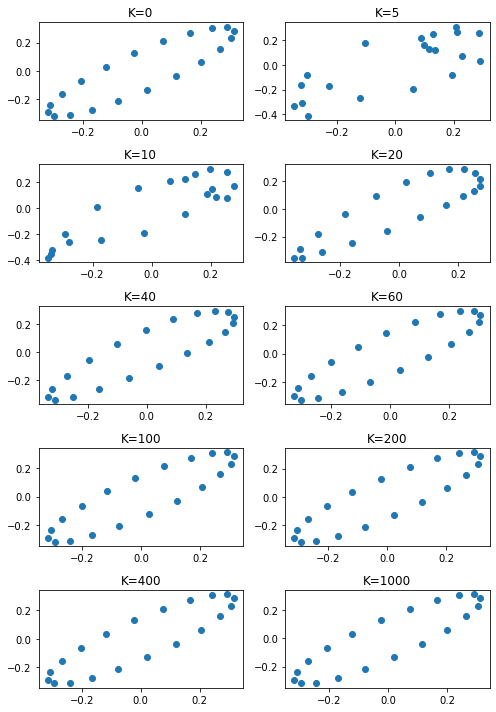

In [25]:
k_values = [0, 5, 10, 20, 40, 60, 100, 200, 400, 1000]

fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize=(7,10))

for i, k in enumerate(k_values):
    axes[int(i/2), int(i%2)].scatter(poly[k-1,:,0], poly[k-1,:,1])
    axes[int(i/2), int(i%2)].set_title("K={}".format(k))
    
fig.tight_layout()

### b.

Takes two point from the points and creates a new point at the middle of those points. However, at the end, it constructs an ellipse.

### c.

$
M = 
\begin{bmatrix}
0.5 & 0.5 & 0 & \dots & 0 \\
0 & 0.5 & 0.5 & \dots & 0 \\
\vdots & \vdots & & \vdots & \vdots \\
0.5 & 0 & 0 & \dots & 0.5 \\
\end{bmatrix}
$ and $ a^{(k)} = \lVert x^{(k)} \rVert$

In [26]:
M = np.zeros(shape=(N,N))

for row_id in range(M.shape[0]):
    if row_id == M.shape[0]-1:
        M[row_id][0] = 1/2
        M[row_id][-1] = 1/2
    else:
        M[row_id][row_id] = 1/2
        M[row_id][row_id+1] = 1/2

In [27]:
def algorithm2(k, x, y):
    
    N = x.shape[0]
    
    poly = np.zeros(shape=(k, N, 2))
    
    for k_id in range(k):
        
        x = M @ x / np.linalg.norm(M @ x)
        y = M @ y / np.linalg.norm(M @ y)
        
        poly[k_id, :, 0] = x
        poly[k_id, :, 1] = y
            
    return poly

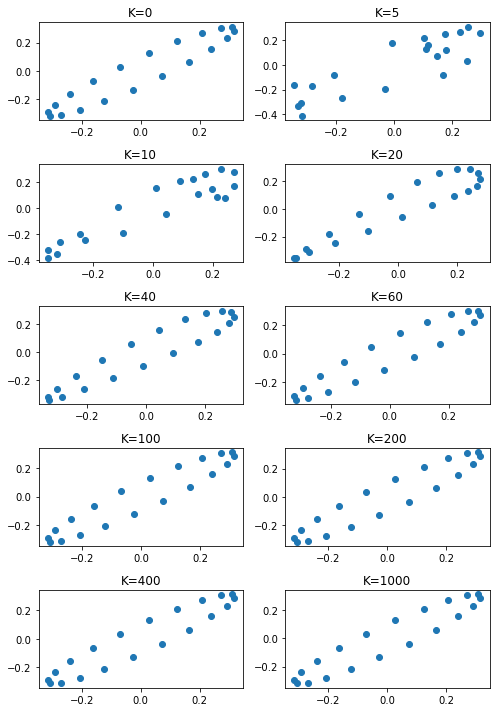

In [28]:
poly2 = algorithm2(k=1000, x=x_init, y=y_init)

k_values = [0, 5, 10, 20, 40, 60, 100, 200, 400, 1000]


fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize=(7,10))

for i, k in enumerate(k_values):
    axes[int(i/2), int(i%2)].scatter(poly2[k-1,:,0], poly[k-1,:,1])
    axes[int(i/2), int(i%2)].set_title("K={}".format(k))
    
fig.tight_layout()

### d.

$Mx = \lambda_nx$ from eigenvector equation.

Thus $\frac{x_1 + x_2}{2} = \lambda_nx_1$, $ x_1 + x_2 = 2\lambda_nx_1$ and $ \frac{x_2}{x_1} = 2\lambda - 1$ \
In general $2\lambda-1 = \frac{x_{i+1}}{x_{i}}$ except the last $\frac{x_{1}}{x_{N}}$ \
Multiply them until the end $N$ and obtain $(2\lambda - 1)^N x_i = x_i$. Divide both sides by $x_i$ and get $(2\lambda - 1)^N = 1$. If we put the eqn. given $ \lambda = (1 + e^{i2\pi n/N})$ it gives $e^{i2\pi n} = 1$ which is true by Euler's eqn.

### e.

If they are not othogonal, dot product of some of the vectors should give non-zero result.

In [29]:
U, s, V_T = np.linalg.svd(M)
sigma = np.zeros_like(M, dtype="float64")
for i, eigenvalue in enumerate(s):
    sigma[i,i] = eigenvalue

In [30]:
for i in range(20):
    for j in range(20):
        dep = V_T[i] @ V_T[j]
        if dep > 0.0001 and i != j:
            print("They are not orthogonal: i:{}, j:{}".format(i,j))

### f.

If we multiply $M$ matrix with itself $K$ times we obtain a convergence. This converged matrix also transforms our vectors into ellipses.

In [31]:
M_sub = np.zeros(shape=(N,N))

for row_id in range(M_sub.shape[0]):
    if row_id == M_sub.shape[0]-1:
        M_sub[row_id][0] = 1/2
        M_sub[row_id][-1] = 1/2
    else:
        M_sub[row_id][row_id] = 1/2
        M_sub[row_id][row_id+1] = 1/2

In [32]:
def multiply(M, iter):
    m_orig = M
    M_new = M.copy()
    for _ in range(iter):
        M_new = M_new@m_orig
        
    return M_new

M_alt = multiply(M_sub, 1000)

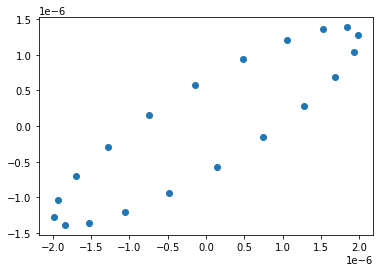

In [33]:
plt.scatter(x_init@M_alt, y_init@M_alt)
plt.show()

## Question 4

### a.

If $c^{(n)}$ is either $0$ or $1$ and $g_n(c^{(n)}) = (c^{(n)} - a)^2 + b = 0$, then either $(1 - a)^2 + b = 0$ or $(0 - a)^2 + b = 0$. \
If we solve linear sytem of equation, \
$1 + a^2 - 2a + b = 0 = a^2 + b$ \
$1 - 2a = 0$ \
$a = \frac{1}{2}, b = -\frac{1}{4}$

### b.

For each cluster and given $d$, it sums over the absolute difference between feature $d$ of each vector in that cluster and the mean of that feature within that cluster. Then does this for all features and sums over. Thus, by minimizing this function, for each vector, the algorithm tries to pick a cluster whose current members' mean is closer to the vector.

### c.

In [34]:
df = pd.read_csv("./data/Q4_points.csv").to_numpy()

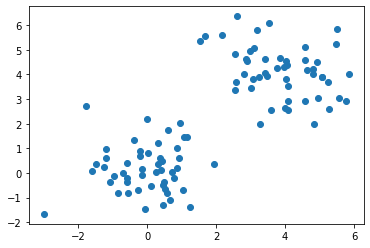

In [35]:
plt.scatter(df[:,0], df[:,1])
plt.show()

### d.

In [36]:
eps = np.finfo(np.float32).eps

In [37]:
from jax import jacfwd

In [38]:
def obj(X, C):
    
    first = jnp.sum(C*jnp.abs(X - jnp.sum(X*C, axis=0) / (jnp.sum(C) + eps)), axis=0)
    second = jnp.sum((1-C)*jnp.abs(X - jnp.sum(X*(1-C), axis=0) / (jnp.sum((1-C)) + eps)), axis=0)
    
    return jnp.sum((first + second)**2)

In [39]:
def const(C):
    return (C - (0.5))**2 - 0.25

In [40]:
def loss_f(X, C, mikro, z):
    return obj(X, C) + mikro * jnp.sum((const(C) + z / (2 * mikro))**2)

In [41]:
# see page 392 eqn 18.12 in IALA
def Levenberg_Marquardt(X, loss, jacobian, c, mikro, z, trust):
    new_c = c - np.linalg.inv(jacobian.T @ jacobian + trust * jnp.eye(jacobian.shape[0])) @ jacobian * loss
    new_loss = loss_f(X, new_c, mikro, z)
    
    return (new_c, trust*0.8) if new_loss < loss else (c, trust * 2)

In [42]:
loss_jacobian_f = jacfwd(loss_f, argnums=1)

def augmented_lagrangian(X, epochs, kmax=10):
    tol = 1e-6
    mikro = 1
    C = np.random.randint(2, size=(df.shape[0],1)).astype("float64")
    C = jnp.array(C)
    z = jnp.zeros_like(C)
    trust = 1
    
    current_c = C
    
    for epoch in range(epochs): 
        
        for k in range(kmax):
            loss = loss_f(X, current_c, mikro, z)
            jacobian = loss_jacobian_f(X, current_c, mikro, z)

            current_c, trust = Levenberg_Marquardt(X, loss, jacobian, current_c, mikro, z, trust)
            
            if np.linalg.norm(2*jacobian.T * loss) < tol:
                break
            
        z = z + 2 * mikro * const(current_c)

        if not jnp.linalg.norm(const(current_c)) < 0.25 * jnp.linalg.norm(const(C)):
            mikro = 2 * mikro

        C = current_c
        
        
    return np.array(C)

    

In [43]:
# To avoid numerical instabilities, try to run until no error
while(True):
    try:
        C = augmented_lagrangian(df, 10)
        break
    except Exception as e:
        #print(e)
        pass

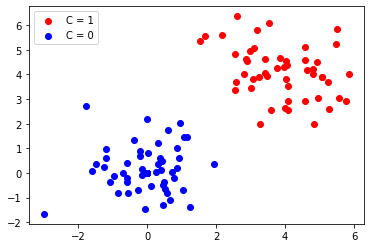

In [44]:
C = C.reshape(-1)
C[C>0.5] = 1
C[C<=0.5] = 0
plt.scatter(df[:,0]*C, df[:,1]*C, c="r", label="C = 1")
plt.scatter(df[:,0]*(1-C), df[:,1]*(1-C), c="b", label="C = 0")
plt.legend()
plt.show()

## Question 5

### a.

$S = \frac{1}{N}\bf{X}^{T}\bf{X}$ is the covariance matrix of X when the mean is zero. (We can always scale it by subtracting mean of it from each element.)

$
\frac{\partial \mathcal{L}_1}{\bf{a_1}} = Sa_1 - \lambda_1 a_1
$
in order to find maximum point, set $ Sa_1 - \lambda_1 a_1 = 0 $ then \
$ Sa_1 = \lambda_1 a_1 $ This means $\lambda_1$ is the first eigenvalue of the $S$ and $a_1$ is the first corresponding eigenvector.

### b.

If we apply SVD to $S=X^TX$ we have, $X^TX = V\Sigma^T\Sigma V^T$ where square-root of the elements of $\Sigma^T \Sigma$ is the eigenvalues of the $X$. Also, the columns of $V$ is the eigenvectors of the X. This means $a_1$ appears as a column of a V matrix and $\lambda_1$ appears as the square of the first eigenvalue of the $X$.

### c.

$L = a_2^TSa_2 - \lambda(a_2^Ta_2 - 1) - \gamma a_1^Ta_2$ \
$
\frac{\partial \mathcal{L}_1}{\bf{a_1}} = Sa_2 - \lambda_2 a_2 - \gamma a_1 = 0
$\
then $\gamma = 0$ so $Sa_2 = \lambda_2 a_2$

Similar to $a_1$, any $a_k$ is the $k$'th column of the matrix $V$ obtained by the SVD $X = U\Sigma V$. 

### d.

In [45]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()
D = faces["images"]

In [46]:
X = D.reshape(400, 4096)

### e.

In [47]:
U, s, V_T = np.linalg.svd(X)

print("First 10 elements of the principal component a_1: \n{}".format(V_T[1][:10]))

First 10 elements of the principal component a_1: 
[-0.02742504 -0.03091407 -0.03455592 -0.03594489 -0.03499276 -0.03332592
 -0.03054291 -0.0267495  -0.02364418 -0.0206004 ]


### f.

In [48]:
z_1 = V_T[:3] @ X[0]
print("Z_1 when K is 3: \n {}".format(z_1))

Z_1 when K is 3: 
 [-41.21981     0.7648589  -2.1319966]


### g.

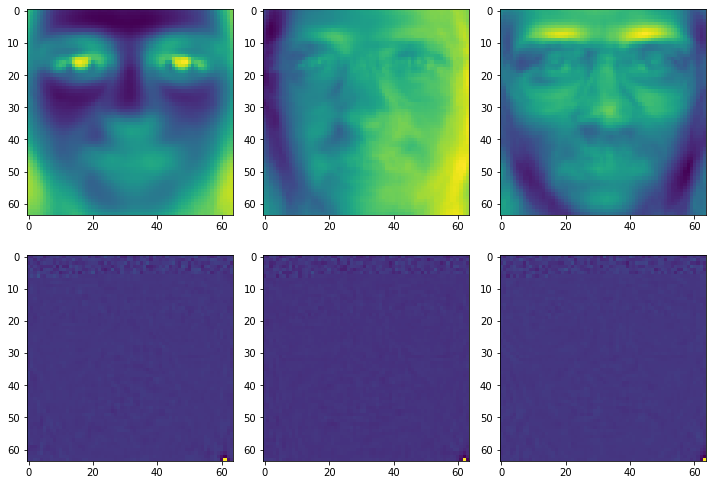

In [49]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(10,7))

axes[0, 0].imshow(V_T[0].reshape(64,64))
axes[0, 1].imshow(V_T[1].reshape(64,64))
axes[0, 2].imshow(V_T[2].reshape(64,64))

axes[1, 0].imshow(V_T[-3].reshape(64,64))
axes[1, 1].imshow(V_T[-2].reshape(64,64))
axes[1, 2].imshow(V_T[-1].reshape(64,64))
    
fig.tight_layout()

## Question 6

### a.

In [50]:
df = pd.read_csv("./data/Q6_bivariate.csv", names=["input", "output"]).to_numpy()

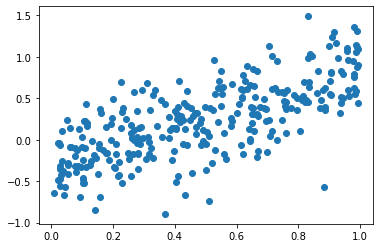

In [51]:
plt.scatter(df[:,0], df[:,1])
plt.show()

### b.

In [52]:
A = df[:, 0:1]
b = df[:, 1:2]

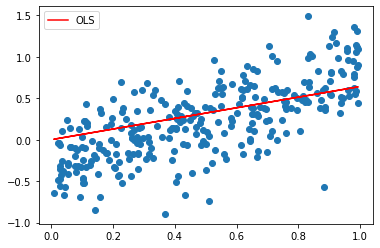

In [53]:
x = (np.linalg.inv(A.T @ A) @ A.T) @ df[:,1:2]
preds = x * df[:, 0:1]
plt.scatter(df[:,0], df[:,1])
plt.plot(df[:,0], preds, color="r", label="OLS")
plt.legend()
plt.show()

### c.

In [54]:
X = np.zeros_like(df)
input_mean = np.mean(df[:, 0])
output_mean = np.mean(df[:, 1])

X[:, 0] = df[:, 0] - input_mean
X[:, 1] = df[:, 1] - output_mean

In [55]:
U, s, V_T = np.linalg.svd(X)
first_principal = V_T[0]

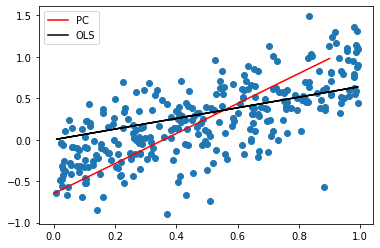

In [56]:
slope = first_principal[1]/first_principal[0]

xs = np.arange(0.0, 1.0, 0.1) 

plt.scatter(df[:,0], df[:,1])
plt.plot(xs, xs*slope + (-slope*input_mean + output_mean), c="r", label="PC")

plt.plot(df[:,0], preds, c="k", label="OLS")
plt.legend()
plt.show()

### d.

In [57]:
from scipy import odr

def f(B,x):
    return B[0]*x + B[1]
wds = [1,2,10,100]
slopes = []
intercepts = []

for wd in wds:
    linear_model = odr.Model(f)
    data = odr.Data(df[:, 0], df[:, 1], wd=wd)
    odreg = odr.ODR(data, linear_model, beta0=[0., 0.])
    output = odreg.run()
    slope, intercept = output.beta
    slopes.append(slope)
    intercepts.append(intercept)

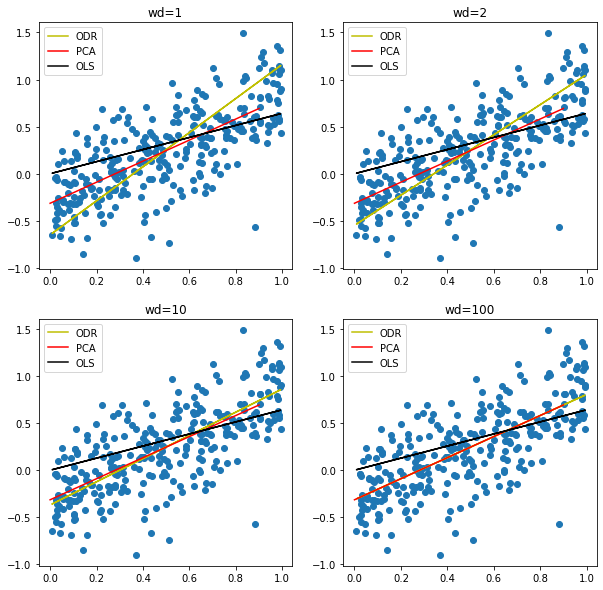

In [58]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))

for i in range(len(wds)):
    axes[i//2,i%2].scatter(df[:,0], df[:,1])
    axes[i//2,i%2].plot(df[:, 0], df[:, 0]*slopes[i] + intercepts[i], color="y", label="ODR")
    axes[i//2,i%2].plot(xs, xs*slope + (-slope*input_mean + output_mean), c="r", label="PCA")
    axes[i//2,i%2].plot(df[:,0], preds, c="k", label="OLS")
    axes[i//2,i%2].set_title("wd={}".format(wds[i]))
    axes[i//2,i%2].legend()


### e.

When **wd** is 1 it is closest to the PCA. However, when $wd=100$ it is closest to the Least Square solution.

First principal component is the vector that maximizes the covariance matrix. On the other hand, **wd** determines the diagonal of the covariance matrix. Since we are using the first component only, when **wd** is 1, we obtain the maximum similarity between **ORD** and **PCA**.

When **wd** increases we use more principal components and get closer to the **OLS** solution where we use all of the matrix.